# DQN

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
from tqdm import tqdm
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F 

import os
import sys
sys.path.append("../scripts")

from plotting import *
from enviroment import *

In [2]:
seeds = [
    960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534, 1822174485, 1871883252, 694388766,
    188312339, 773370613, 2125204119, 2041095833, 1384311643, 1000004583, 358485174, 1695858027, 762772169,
    437720306, 939612284
]
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
source = 507
target = 235

In [3]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, values):
        """Save a transition"""
        self.memory.append(values)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, states_dim, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(states_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, env, learning_rate = 0.3, gamma = 0.99, tau = 0.05, max_epsilon = 1, min_epsilon = 0.1, n_episodes = 1000, max_steps = 1000, batch_size = 64, feature_type="position"):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.n_states = env.get_n_states()
        self.feature_type = feature_type
        self.input_dim = self.get_features(0).shape[0]
        self.policy_net = DQN(self.input_dim, self.n_states)
        self.target_net = DQN(self.input_dim, self.n_states)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        #self.policy_net.to(device)
        #self.target_net.to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(1000)

    def get_features(self, state):
        """Return a torch tensor with the features of the state"""
        if self.feature_type == "position":
            features = torch.Tensor([
                self.env.G.nodes[state]["x"],
                self.env.G.nodes[state]["y"],
                len(list(self.env.G.neighbors(state)))
            ])
        elif self.feature_type == "position_state":
            features = torch.zeros(self.n_states + 3, dtype=torch.float32)#, device=device)
            features[state] = 1
            features[-1] = self.env.G.nodes[state]["x"]
            features[-2] = self.env.G.nodes[state]["y"]
            features[-3] = len(list(self.env.G.neighbors(state)))
        elif self.feature_type == "position_action":
            features = torch.zeros(self.n_states + 3, dtype=torch.float32)
            neighbors = list(self.env.G.neighbors(state))
            features[neighbors] = 1
            features[-1] = self.env.G.nodes[state]["x"]
            features[-2] = self.env.G.nodes[state]["y"]
            features[-3] = len(list(self.env.G.neighbors(state)))

        
        return features
    

    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
        

    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        neighbors = list(self.env.G.neighbors(state))
        # transform neighbors to boolean array
        neighbors = [True if neighbor in neighbors else False for neighbor in range(self.n_states)]
        actions_values = self.policy_net(self.get_features(state))
        # make non-neighbors equal to -inf so they are not chosen
        neighbors_boolean = torch.tensor(neighbors, dtype=torch.bool) #, device=device)
        actions_values[~neighbors_boolean] = -float("Inf")
        return actions_values.argmax().view(1).item()
    

    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return random.choice(neighbors)
        else:
            return self.greedy_policy(state)
    

    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in tqdm(range(self.n_episodes)):
            self.generate_episode(self.epsilon)
            self.update_epsilon()
        
        with torch.no_grad():
            self.get_policy()

    
    def generate_episode(self, epsilon):
        state = self.env.reset()
        state_features = self.get_features(state)
        self.episode_rewards.append(0)

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward
            new_state_features = self.get_features(new_state)

            self.memory.push(torch.cat([state_features, new_state_features, torch.tensor([action, reward], dtype=torch.float32)]))
            state = new_state

            self.optimize_model()

            # soft update of weights
            target_net_state_dict = self.target_net.state_dict()
            policy_net_state_dict = self.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
            self.target_net.load_state_dict(target_net_state_dict)

            if done:
                break

    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = torch.stack(self.memory.sample(self.batch_size))
        
        state_batch = transitions[:, :self.input_dim].view(-1, self.input_dim)
        new_state_batch = transitions[:, (self.input_dim):2*(self.input_dim)].view(-1, self.input_dim)
        action_batch = transitions[:, -2].view(-1, 1).long()
        reward_batch = transitions[:, -1].view(-1, 1)
        
        Q_s_a = self.policy_net(state_batch).gather(1, action_batch)
        Q_s_a_prime = self.target_net(new_state_batch).max(dim=1)[0].view(-1, 1).detach()
        
        
        loss = F.mse_loss(Q_s_a, reward_batch + self.gamma * Q_s_a_prime)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_policy(self):
        states_features = [self.get_features(state) for state in range(self.env.get_n_states())]
        states_features = torch.stack(states_features)
        states_values = self.policy_net(states_features).cpu().numpy()
        self.policy = states_values.argmax(axis=1)
        self.policy = {state: action for state, action in enumerate(self.policy)}

In [28]:
env = Environment(G, source, target, "weighted")
agent = DQNAgent(env, n_episodes = 1000)

In [ ]:
agent.train()

In [ ]:
agent.get_features(0)

tensor([-47.0632, -22.9120,   2.0000])

In [ ]:
agent.greedy_policy(0)

386

In [ ]:
agent.epsilon_greedy_policy(0, 1)

418

In [ ]:
agent.memory.sample(5)[0]

tensor([-4.7064e+01, -2.2914e+01,  1.0000e+00, -4.7060e+01, -2.2913e+01,
         2.0000e+00,  5.1800e+02, -2.7745e-02])

In [ ]:
agent.memory.sample(5)[0].shape

torch.Size([8])

In [ ]:
agent.memory.sample(5)[0].dtype

torch.float32

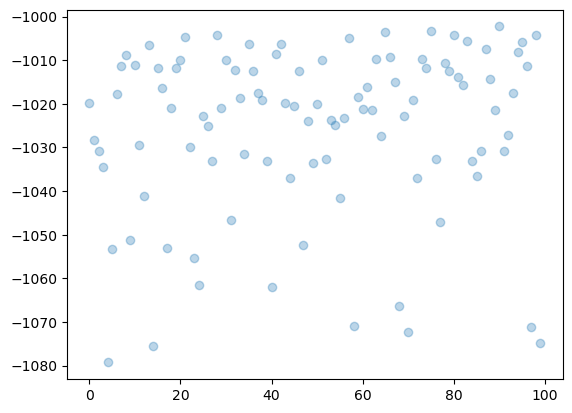

In [ ]:
plt.scatter(list(range(len(agent.episode_rewards))), agent.episode_rewards, alpha = 0.3)

In [ ]:
agent.policy

{0: 318,
 1: 318,
 2: 318,
 3: 318,
 4: 318,
 5: 318,
 6: 318,
 7: 318,
 8: 318,
 9: 318,
 10: 318,
 11: 318,
 12: 318,
 13: 318,
 14: 318,
 15: 318,
 16: 318,
 17: 318,
 18: 318,
 19: 318,
 20: 318,
 21: 318,
 22: 318,
 23: 318,
 24: 318,
 25: 318,
 26: 318,
 27: 318,
 28: 318,
 29: 318,
 30: 318,
 31: 318,
 32: 318,
 33: 318,
 34: 318,
 35: 318,
 36: 318,
 37: 318,
 38: 318,
 39: 318,
 40: 318,
 41: 318,
 42: 318,
 43: 318,
 44: 318,
 45: 318,
 46: 318,
 47: 318,
 48: 318,
 49: 318,
 50: 318,
 51: 318,
 52: 318,
 53: 318,
 54: 318,
 55: 318,
 56: 318,
 57: 318,
 58: 318,
 59: 318,
 60: 318,
 61: 318,
 62: 318,
 63: 318,
 64: 318,
 65: 318,
 66: 318,
 67: 318,
 68: 318,
 69: 318,
 70: 318,
 71: 318,
 72: 318,
 73: 318,
 74: 318,
 75: 318,
 76: 318,
 77: 318,
 78: 318,
 79: 318,
 80: 318,
 81: 318,
 82: 318,
 83: 318,
 84: 318,
 85: 318,
 86: 318,
 87: 318,
 88: 318,
 89: 318,
 90: 318,
 91: 318,
 92: 318,
 93: 318,
 94: 318,
 95: 318,
 96: 318,
 97: 318,
 98: 318,
 99: 318,
 100: 318,